In [9]:
from treams.jcyl._tmatrixc import globalt
import treams
import cavity

from jax import config
config.update("jax_enable_x64", True) #important -> else aaa fails

import jax.numpy as np
from scipy.constants import e, h, c as c0
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

POLARIZATION = 0 # 0=>TE ; 1=>TM
RADIUS = 110/2
NUM_CYL = 50

materials = [treams.Material(4.213**2 + 0.07j), treams.Material(1.723**2 + 0.01j)]
kzs=[0]

E_max = 2.3
E_min = 2.51

In [10]:
def _tm_cavity(E_ph, mmax=1, radius=RADIUS, pitch=165, A=200, L=1820, sigma=1000, num_cyl=NUM_CYL):
    omega = 2*np.pi*E_ph*(e/h)
    k0 = omega/c0*1e-9
    kzs = [0]
    positions = cavity.scatterer_positions(A, sigma, pitch, num_cyl, L)
    radii = np.array([RADIUS]*NUM_CYL)
    finalt, modes, positions = globalt(mmax, kzs, k0, radii, positions, materials, pol_filter=POLARIZATION)

    return finalt, modes, positions

def tm_cavity(E_phs: np.ndarray, L:float=1820) -> tuple[tuple[treams.PhysicsArray], tuple[treams.PhysicsArray]]:
    """returns the incident and scattered fields at a given (complex) Energy"""
    _tm_cavity(E_phs[0], L=L)[0]

    res = [_tm_cavity(E_ph, L=L)[0] for E_ph in tqdm(E_phs)]
    return np.array(res)

In [11]:
finalt, modes, positions = _tm_cavity(1)

In [12]:
pidx = np.argmin(np.abs(positions[:, 1]))
t_idx = np.argmax(modes[0]==pidx)

In [13]:
modes

(Array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
         5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
        11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16,
        17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22,
        22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28,
        28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33,
        34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39,
        39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45,
        45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49],      dtype=int64),
 Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0

In [14]:
print(t_idx)

36


In [15]:
z_k_r = np.linspace(E_min, E_max, 200)
z_k_i = 0

z_k = z_k_r + 1j*z_k_i

In [16]:
f_k = tm_cavity(z_k)[:,t_idx,t_idx]

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 

/home/jd/miniconda3/envs/jat/lib/python3.9/site-packages/jax/_src/array.py:390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


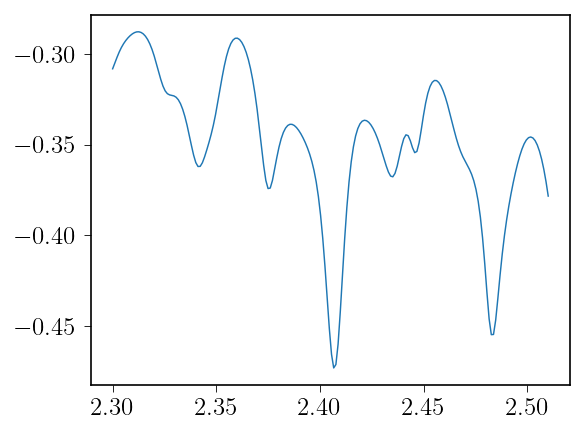

In [ ]:
plt.plot(z_k_r, f_k)

In [25]:
def f(A):
    tm = _tm_cavity(2.4, A=A)[0]
    return np.real(tm[t_idx,t_idx])

In [26]:
import jax
g = jax.grad(f)
g(1820.0)

Array(nan, dtype=float64, weak_type=True)

In [24]:
_tm_cavity(z_k[0], A=1820.0)[0][t_idx,t_idx]

Array(-0.40455885+0.46846967j, dtype=complex128)